# Data Exploration

We make predictions on the clean dataset to get the baseline accuracy and confidence for the data.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image
from torchvision import models
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Import custom modules


## Predict on clean dataset

In [9]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset/dev_dataset.csv", "data/ImageNet_subset/images/", transform=preprocess))

In [ ]:
## Predict for all clean images

accurcy_top1_list = []
accurcy_top5_list = []
confidence_list = []
label_index = []

i = 0
for image_as_tensor, label in data_loader:      
    clear_output(wait=True)
    print("Sample: "+ str(i))
       
    # Predict with clean image
    _, top1, top5, conf, label = predict(model, image_as_tensor, label, return_grad=False)

    # Add accuracies and confidences for clean and adversarial example
    accurcy_top1_list.append(top1)
    accurcy_top5_list.append(top5)
    confidence_list.append(conf)
    label_index.append(label)
    i += 1
    
accurcy_top1 = np.mean(accurcy_top1_list)
accurcy_top5 = np.mean(accurcy_top5_list)
confidence = np.mean(confidence_list)
    
       
## Print results
print("Accuracy top1: {:.2f}\nAccuracy top5: {:.2f}\nConfidence: {:.2f}".format(accurcy_top1, accurcy_top5, confidence))   
  
    
## Save results
result = pd.DataFrame()
result["Accuracy Top 1"] = accurcy_top1_list
result["Accuracy Top 5"] = accurcy_top5_list
result["Confidence"] = confidence_list
result["Class Index"] = label_index
#result.to_csv("results/Clean-Predictions.csv")

In [35]:
result = pd.read_csv("results/Clean-Predictions.csv", index_col=0)
result = result.rename(columns={"Label": "Class Index"})
result

,Accuracy Top 1,Accuracy Top 5,Confidence,Class Index,Sample
0,1,1,0.521527,305,0
1,0,1,0.230145,738,1
2,1,1,0.846168,243,2
3,1,1,0.994146,559,3
4,1,1,0.602645,438,4
...,...,...,...,...,...
995,1,1,0.338009,526,995
996,1,1,0.485719,703,996
997,0,1,0.175319,751,997
998,1,1,0.555623,562,998


### Aggregated results

In [36]:
## Aggregate class index and average confidence per class

classes = result["Class Index"].unique().tolist()

conf_mean = []
conf_std = []

for c in classes:
    conf_mean.append(np.mean(result.loc[result["Class Index"] == c]["Confidence"]))
    conf_std.append(np.std(result.loc[result["Class Index"] == c]["Confidence"]))
  
result_aggregated = pd.DataFrame()
result_aggregated["Class Index"] = classes
result_aggregated["Confidence Mean"] = conf_mean
result_aggregated["Confidence Std"] = conf_std

result_aggregated.sort_values(by=["Confidence Mean"], ascending=False, inplace=True)
result_aggregated.reset_index(inplace=True, drop=True)


# Add frequency
freq = result["Class Index"].value_counts().tolist()
cols = result["Class Index"].value_counts().index.tolist()

sub = pd.DataFrame()
sub["Class Index"] = cols
sub["Frequency"] = freq

result_aggregated = pd.merge(result_aggregated, sub, on="Class Index")


#Add class names
class_names = []

for index in result_aggregated["Class Index"].tolist():
    class_names.append(idx_to_name(index))

result_aggregated["Class Name"] = class_names
#result_aggregated.to_csv("results/Clean-Predictions_aggregated_with_class_names.csv")

In [38]:
result = pd.read_csv("results/Clean-Predictions_aggregated_with_class_names.csv", index_col=0)
result_aggregated = pd.read_csv("results/Clean-Predictions_aggregated_with_class_names.csv", index_col=0)

### Which classes are represented?

We can see that out of the 1000 classes there are 452 distinct onces represented in the data. There are 8 images of `ballplayer, baseball player` (class index `981`) in the data, which is the most represented class.

In [16]:
print("Number of distinct classes in data: " + str(len(result["Class Index"].unique())))

result_aggregated.sort_values(by=["Frequency"], ascending=False, inplace=False)[0:10]

KeyError: 'Class Index'

### Which classes have highest and lowest confidence?

In [12]:
# Highest confidence scores
result_aggregated.sort_values(by=["Confidence Mean"], ascending=False, inplace=False)[0:10]

,Class Index,Confidence Mean,Confidence Std,Frequency,Class Name
0,427,0.999936,0.000000,1,"barrel, cask"
1,528,0.999653,0.000000,1,"dial telephone, dial phone"
2,599,0.998496,0.000000,1,honeycomb
3,429,0.997868,0.000000,1,baseball
4,100,0.997462,0.000000,1,"black swan, Cygnus atratus"
5,915,0.997383,0.000278,2,yurt
6,84,0.997097,0.000000,1,peacock
7,608,0.996442,0.000000,1,"jean, blue jean, denim"
8,559,0.994146,0.000000,1,folding chair
9,991,0.994097,0.000000,1,coral fungus


In [14]:
# Lowest confidence scores
result_aggregated.sort_values(by=["Confidence Mean"], ascending=True, inplace=False)[0:10]

,Class Index,Confidence Mean,Confidence Std,Frequency,Class Name
451,774,0.041640,0.0,1,sandal
450,212,0.043343,0.0,1,English setter
449,431,0.049087,0.0,1,bassinet
448,241,0.055452,0.0,1,EntleBucher
447,907,0.058586,0.0,1,wine bottle
446,916,0.060198,0.0,1,"web site, website, internet site, site"
445,824,0.066721,0.0,1,stole
444,822,0.070870,0.0,1,steel drum
443,523,0.073467,0.0,1,crutch
442,735,0.079745,0.0,1,poncho


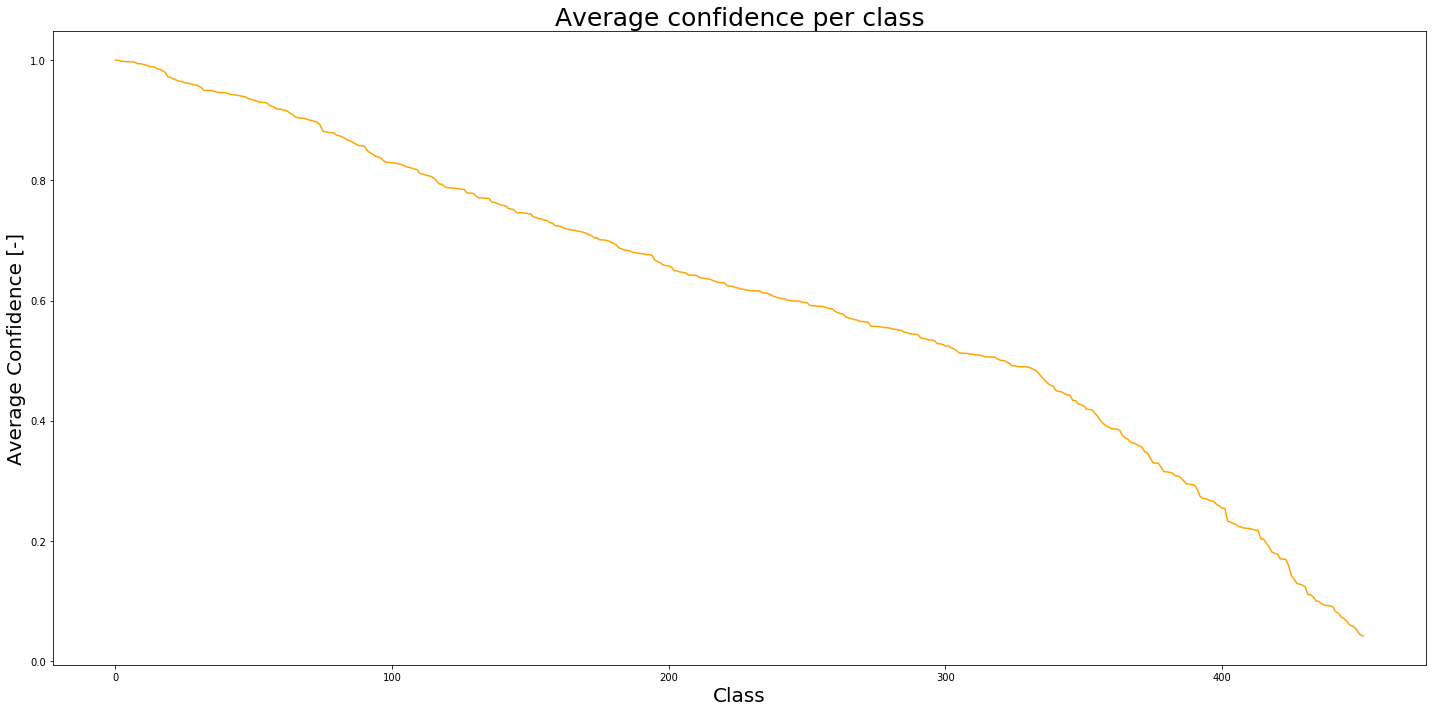

In [10]:
result_aggregated = pd.read_csv("results/Clean-Predictions_aggregated_with_class_names.csv", index_col=0)

plt.plot(result_aggregated["Confidence Mean"], color='orange')
plt.xticks()
plt.title("Average confidence per class", fontsize=25)
plt.ylabel("Average Confidence [-]", fontsize=20)
plt.xlabel("Class", fontsize=20)
plt.tight_layout()
plt.savefig("plots/Data_Exploration/Data_Exploration-Average_confidence_per_class.pdf")
plt.savefig("plots/Data_Exploration/Data_Exploration-Average-confidence_per_class.png")

Expectation: Confidence is high for correct classifications, low for false classifications. For top 5 is should be slightly lower.

In [18]:
conf_top1 = np.mean(result.loc[result["Accuracy Top 1"] == 1]["Confidence"])
conf_top5 = np.mean(result.loc[result["Accuracy Top 5"] == 1]["Confidence"])
conf_false = np.mean(result.loc[result["Accuracy Top 1"] == 0]["Confidence"])
print("Confidence scores\nTop 1: {:.2f}\nTop 5: {:.2f}\nFalse: {:.2f}".format(conf_top1, conf_top5, conf_false))

Confidence scores
Top 1: 0.69
Top 5: 0.63
False: 0.28


## Inspect confidence distributions of predictions
How clear does the highest confidence stand out from the second highest in the prediction?

--> Analyze top 5 confidences

## Inspect images

Let's inspect the images with the highest confidence score.

In [22]:
def get_image_by_class_index(class_index):
    '''
    Displays an image of the given class_index. If multiple images of this class exist, the first is displayed.
    '''
    for i in range(1000):
        image_clean, target_label = data_loader.dataset[i]

        if target_label.numpy() == class_index:
            image_clean.unsqueeze_(0)
            target_label
            _ = show_tensor_image(image_clean)    

766


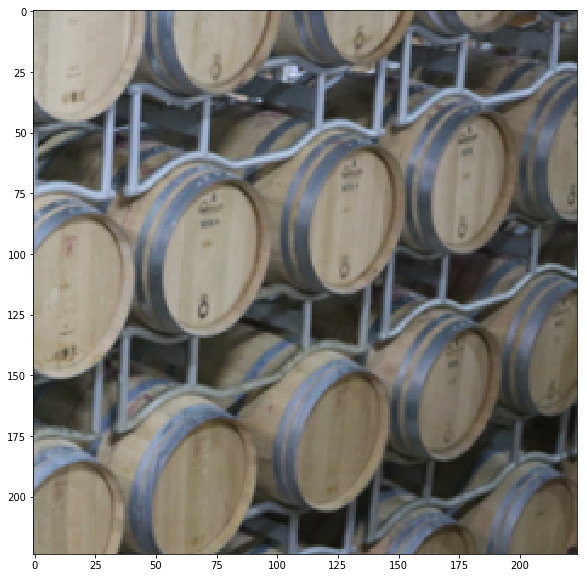

In [23]:
get_image_by_class_index(427)

590


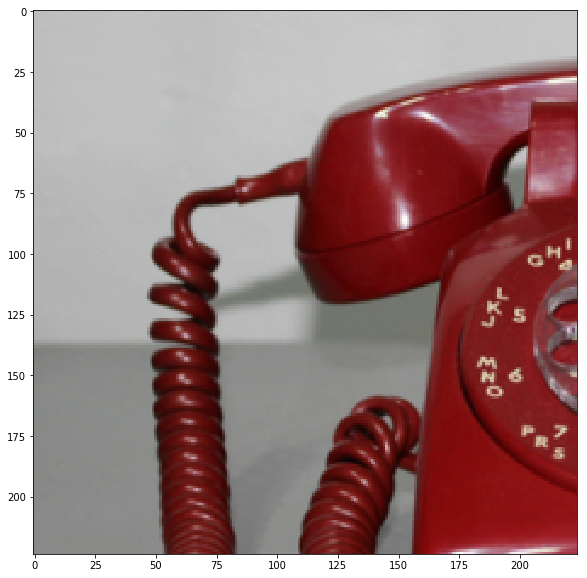

In [24]:
get_image_by_class_index(528)

132


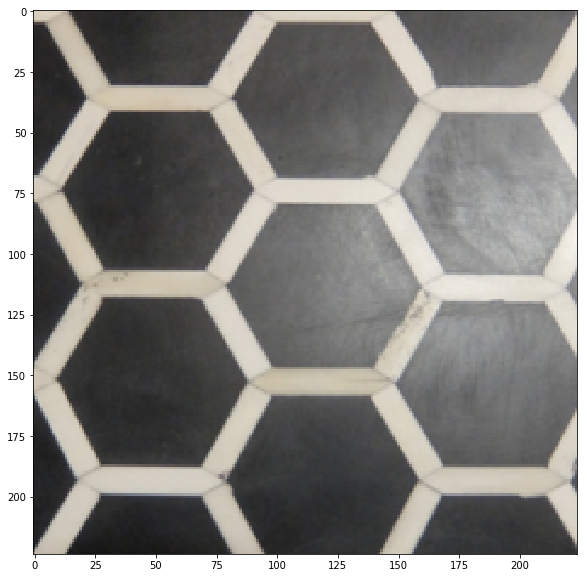

In [25]:
get_image_by_class_index(599)

241


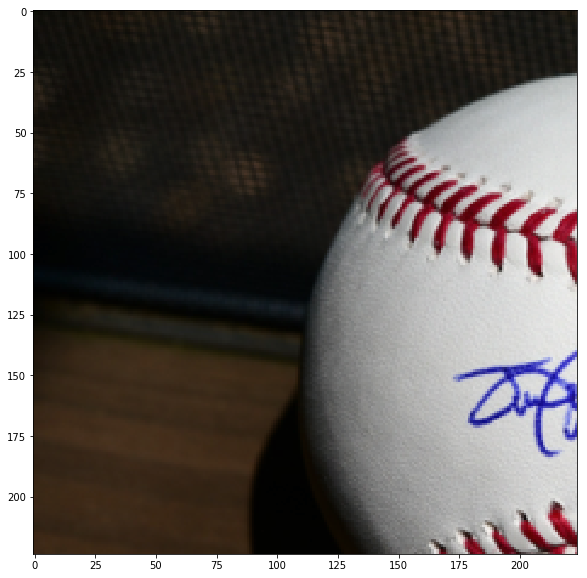

In [26]:
get_image_by_class_index(429)

Images with lowest confidence scores are:

958


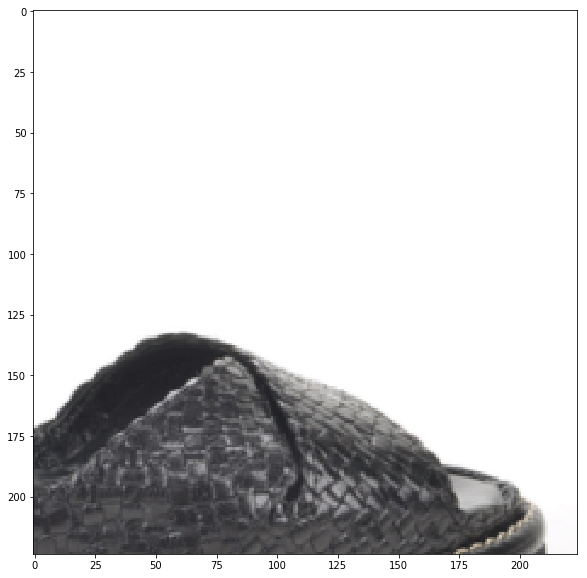

In [27]:
get_image_by_class_index(774)

## References

[1] &emsp; Russakovsky et al. (2015) *ImageNet Large Scale Visual Recognition Challenge*

[2] &emsp; Kurakin et al. (2018) *Adversarial Attacks and Defences Competition*

[3] &emsp; Szegedy et al. (2015) *Going Deeper with Convolutions*